# Uncertainty-Aware Learning from Demonstration Using Mixture Density Networks with Sampling-Free Variance Modeling

**Abstract**

In this paper, we propose an uncertainty-aware
learning from demonstration method by presenting a novel
uncertainty estimation method utilizing a mixture density
network appropriate for modeling complex and noisy human
behaviors. The proposed uncertainty acquisition can be done
with a single forward path *without Monte Carlo sampling* and
is suitable for real-time robotics applications. 

<center>
<img src='https://www.researchgate.net/profile/Baptiste_Feron/publication/325194613/figure/fig2/AS:643897080434701@1530528435323/Mixture-Density-Network-The-output-of-a-neural-network-parametrizes-a-Gaussian-mixture.png' width=400>
</center>


**Total Variance**

Total predictive variance is the sum of
aleatoric uncertainty and epistemic uncertainty

$$
\begin{align}
E\rVert y - \hat{f}(x) \rVert^2 &=E\rVert y -f(x) +f(x)- \hat{f}(x) \rVert^2\\
&=E\rVert y - f(x) \rVert^2 + E\rVert f(x) - \hat{f}(x) \rVert^2 \\
&=\sigma_a^2 + \sigma_e^2
\end{align}
$$



**Epistemic uncertainty**

epistemic uncertainty models the ignorance
of the predictive model where it can be explained away given
an enough number of training data.

$$
\sigma_e^2 =E\rVert f(x) - \hat{f}(x) \rVert^2
$$

**Aleatoric Uncertainty**

aleatoric uncertainty captures the uncertainty
in the data generating process, e.g., inherent randomness of a
coin flipping or measurement noise. This type of uncertainty
cannot be reduced even if we collect more training data. 

$$
y=f(x) + \epsilon
$$

- $\epsilon = \sigma_e$

**Expectation of Mixture density**

$$
\begin{align}
E[y|x]&=\sum_{j=1}^K\pi_j(x) \int \mathcal{N}(y|u_j(x), \Sigma_j(x)) dy\\
&= \sum_{j=1}^K\pi_j(x)u_j({x})
\end{align}
$$

**Variance of Mixture density**

$$
\begin{align}
V[y|x] &= \int \rVert  y-E[y|x]\rVert ^ 2p(y|x)dy \\
&= \sum_{j=1}^K\pi_j \int  \rVert  y-\sum_{k=1}^K\pi_k(x)u_k({x})\rVert ^ 2 \mathcal{N}(y|u_j(x), \Sigma_j(x)) dy
\end{align}
$$

$$
\begin{align}
V[y|x] &=\sum_{j=1}^K\pi_j(x)\Sigma_j(x) + \sum_{j=1} ^ K\pi_j(x)\rVert u_j(x)- \sum_{k=1}^K\pi_k(x)u_k(x) \rVert^2
\end{align}
$$

- epistemic uncertainty

$$\sum_{j=1} ^ K\pi_j(x)\rVert u_j(x)- \sum_{k=1}^K\pi_k(x)u_k(x) \rVert^2 =E_{k \sim\pi}(V(y|x, k))$$

- aleatoric uncertainty

$$
\sum_{j=1}^K\pi_j(x)\Sigma_j(x) = V_{k \sim\pi}(E[y|x, k])
$$





In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from torch.distributions import Normal, OneHotCategorical

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch.nn.functional as F
from skimage.transform import resize
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline  

## Define: model


In [0]:
class MixtureDensityNetwork(nn.Module):
    """
    Mixture density network.
    [ Bishop, 1994 ]
    Parameters
    ----------
    dim_in: int; dimensionality of the covariates
    dim_out: int; dimensionality of the response variable
    n_components: int; number of components in the mixture model
    """
    def __init__(self, dim_in, dim_out, n_components):
        super().__init__()
        self.pi_network = CategoricalNetwork(dim_in, n_components)
        self.normal_network = MixtureDiagNormalNetwork(dim_in, dim_out,
                                                       n_components)

    def forward(self, x):
        return self.pi_network(x), self.normal_network(x)

    def loss(self, x, y):
        pi, normal = self.forward(x)
        loglik = normal.log_prob(y.unsqueeze(1).expand_as(normal.loc))
        loglik = torch.sum(loglik, dim=2)
        loss = -torch.logsumexp(torch.log(pi.probs) + loglik, dim=1)
        return loss

    def sample(self, x):
        pi, normal = self.forward(x)
        samples = torch.sum(pi.sample().unsqueeze(2) * normal.sample(), dim=1)
        return samples

    def get_variance(self, x):
        '''Computer Variance
        Args
            x: input data, torch.Tensor.
        Returns
            List of [epistemic uncertainty, aleatoric uncertainty]
        '''
        pi, normal = self.forward(x)
        loc, scale = normal.loc, normal.scale
        aleatoric = torch.sum(pi.probs * torch.squeeze(scale, dim=-1), dim=-1) # shape: (batch_size, )
        loc_average = torch.sum(pi.probs * torch.squeeze(loc, dim=-1), dim=-1) # shape: (batch_size, )
        loc_diff = torch.squeeze(loc, dim=-1) - torch.unsqueeze(loc_average, dim=-1)
        loc_diff_sq = loc_diff ** 2
        epistemic = torch.sum(pi.probs * loc_diff_sq, dim=-1) # shape: (batch_size, )
        return aleatoric.detach().numpy(), epistemic.detach().numpy()



class MixtureDiagNormalNetwork(nn.Module):

    def __init__(self, in_dim, out_dim, n_components, hidden_dim=None):
        super().__init__()
        self.n_components = n_components
        if hidden_dim is None:
            hidden_dim = in_dim
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, 2 * out_dim * n_components),
        )

    def forward(self, x):
        params = self.network(x)
        mean, sd = torch.split(params, params.shape[1] // 2, dim=1)
        mean = torch.stack(mean.split(mean.shape[1] // self.n_components, 1))
        sd = torch.stack(sd.split(sd.shape[1] // self.n_components, 1))
        return Normal(mean.transpose(0, 1), torch.exp(sd).transpose(0, 1))

class CategoricalNetwork(nn.Module):

    def __init__(self, in_dim, out_dim, hidden_dim=None):
        super().__init__()
        if hidden_dim is None:
            hidden_dim = in_dim
        self.network = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):
        params = self.network(x)
        return OneHotCategorical(logits=params)

# Toy dataset

In [0]:
model = MixtureDensityNetwork(1, 1, n_components=3)
optimizer = optim.Adam(model.parameters(), lr=0.005)
x = torch.Tensor(x)
y = torch.Tensor(y)

epistemic, aleatoric = model.get_variance(x)

In [0]:
e, a = epistemic.detach().numpy(), aleatoric.detach().numpy()

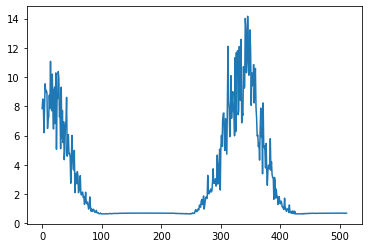

In [89]:
plt.plot(e)
plt.show()

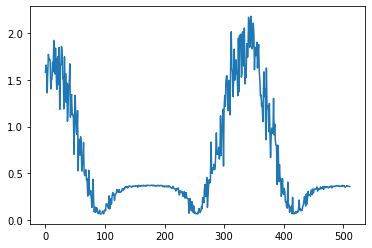

In [90]:
plt.plot(a)
plt.show()

In [0]:
# Make toy dataset
def gen_data(n=512):
    y = np.linspace(-1, 1, n)
    x = 7 * np.sin(5 * y) + 0.5 * y + 0.5 * np.random.randn(*y.shape)
    return x[:,np.newaxis], y[:,np.newaxis]

def plot_data(x, y):
    plt.hist2d(x, y, bins=35)
    plt.xlim(-8, 8)
    plt.ylim(-1, 1)
    plt.axis('off')

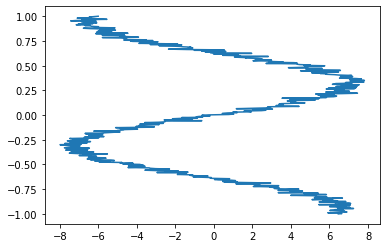

In [14]:
x, y = gen_data()
plt.plot(x, y)
plt.show()

# Train

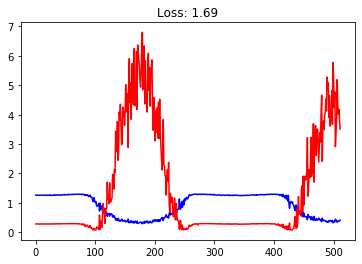

INFO:__main__:Iter: 0	Loss: 1.69


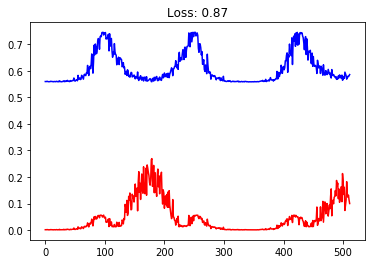

INFO:__main__:Iter: 100	Loss: 0.87


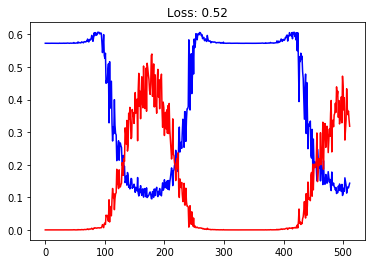

INFO:__main__:Iter: 200	Loss: 0.52


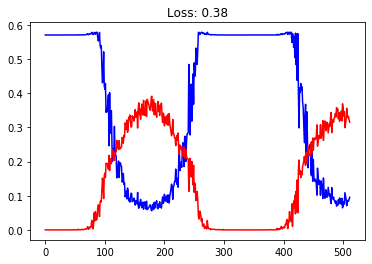

INFO:__main__:Iter: 300	Loss: 0.38


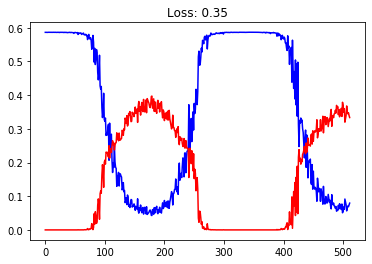

INFO:__main__:Iter: 400	Loss: 0.35


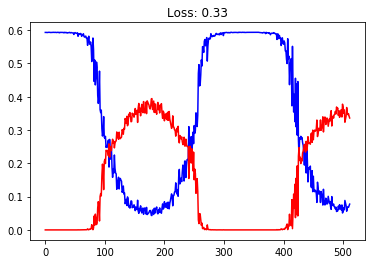

INFO:__main__:Iter: 500	Loss: 0.33


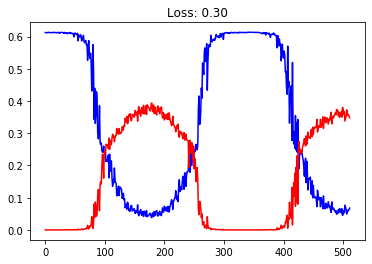

INFO:__main__:Iter: 600	Loss: 0.30


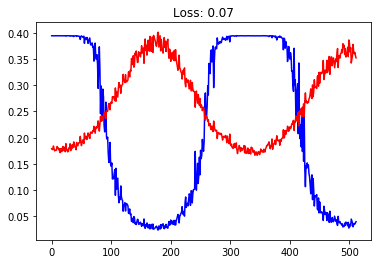

INFO:__main__:Iter: 700	Loss: 0.07


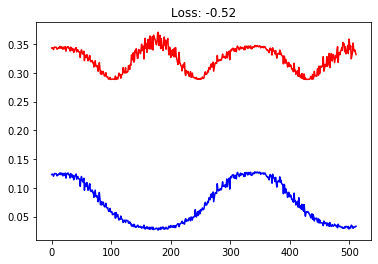

INFO:__main__:Iter: 800	Loss: -0.52


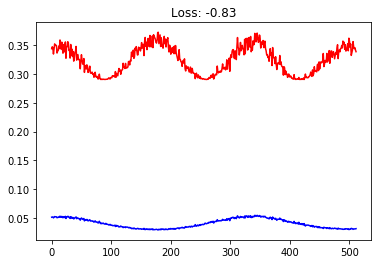

INFO:__main__:Iter: 900	Loss: -0.83


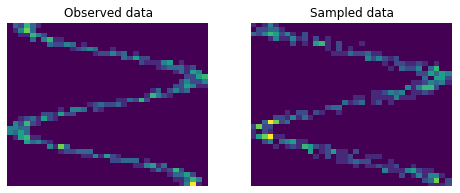

In [96]:
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

model = MixtureDensityNetwork(1, 1, n_components=3)
optimizer = optim.Adam(model.parameters(), lr=0.005)
x = torch.Tensor(x)
y = torch.Tensor(y)
for i in range(1000):
    optimizer.zero_grad()
    loss = model.loss(x, y).mean()
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        epistemic, aleatoric = model.get_variance(x)
        plt.plot(epistemic, color='b')
        plt.plot(aleatoric, color='r')
        plt.title(f'Loss: {loss.data:.2f}')
        plt.show()
        logger.info(f"Iter: {i}\t" + f"Loss: {loss.data:.2f}")

samples = model.sample(x)
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plot_data(x[:,0].numpy(), y[:,0].numpy())
plt.title("Observed data")
plt.subplot(1, 2, 2)
plot_data(x[:,0].numpy(), samples[:,0].numpy())
plt.title("Sampled data")
plt.show()

## Train

# In-distribution